In [64]:
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
df = pd.read_csv('data/owid_co2_data.csv')
df.head()

,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,0.002,NaN,NaN,NaN,0.015,0.002,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,0.011,NaN,NaN,NaN,0.021,0.003,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,0.012,NaN,NaN,NaN,0.026,0.003,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,0.012,NaN,NaN,NaN,0.032,0.004,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001733e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,0.013,NaN,NaN,NaN,0.038,0.005,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


In [66]:
df = df.filter(['iso_code','country','year', 'co2', 'population'], axis=1)
df.head()

,iso_code,country,year,co2,population
0,AFG,Afghanistan,1949,0.015,7624058.0
1,AFG,Afghanistan,1950,0.084,7752117.0
2,AFG,Afghanistan,1951,0.092,7840151.0
3,AFG,Afghanistan,1952,0.092,7935996.0
4,AFG,Afghanistan,1953,0.106,8039684.0


In [67]:
#Removing null rows that contains null values in co2 column
df = df[df.co2.notna()]

In [68]:
x = df.iso_code.value_counts()
print(x)

OWID_WRL    271
GBR         271
CAN         236
DEU         229
POL         221
           ... 
ATA          21
TLS          19
CXR          14
OWID_KOS     13
PRI           1
Name: iso_code, Length: 219, dtype: int64


In [71]:
#Removing rows with year less than 1950
filtered_df = df.drop(df[df.year < 1950].index)

#Since this study consists of the analysis of climate change from 1950
#The countries that appear less than 70 times are not considered because the lack of data
freq_table = filtered_df.iso_code.value_counts()

countries_to_delete = []
for iso_code, value in freq_table.items():
    if value < 70:
        countries_to_delete.append(iso_code)

for iso_code in countries_to_delete:
    filtered_df = filtered_df.drop(filtered_df[filtered_df.iso_code == iso_code].index)

In [72]:
import numpy as np
from scipy import stats

#Calculate co2 mean
mean = filtered_df.co2.mean()
print('co2 mean: ', round(mean, 3))
print('---------------------------------------------')

#Calculate co2 median
median = filtered_df.co2.median()
print('co2 median: ', round(median, 3))
print('---------------------------------------------')

#Calculate co2 trimmed mean
co2_sorted = filtered_df.co2.sort_values()
co2_sorted = co2_sorted.reset_index(drop=True)
limit = 0.1
limits = (co2_sorted[round(filtered_df.co2.shape[0]*limit)], 
          co2_sorted[round(filtered_df.co2.shape[0]*(1-limit))])
trimmed_mean = stats.tmean(co2_sorted, limits=limits)
print("co2 trimmed mean:", round(trimmed_mean,2), "with limits:", limits)
print('---------------------------------------------')

#Calculate co2 variance
variance = filtered_df.co2.var()
print('co2 variance: ', round(variance, 3))
print('---------------------------------------------')

#Calculate co2 variance
standard_deviation = filtered_df.co2.std()
print('co2 standard deviation: ', round(standard_deviation, 3))
print('---------------------------------------------')

#Calculate co2 variance
mean_absolute_deviation = filtered_df.co2.mad()
print('co2 mean absolute deviation: ', round(mean_absolute_deviation, 3))
print('---------------------------------------------')

co2 mean:  519.314
---------------------------------------------
co2 median:  10.876
---------------------------------------------
co2 trimmed mean: 61.47 with limits: (0.231, 632.537)
---------------------------------------------
co2 variance:  5001093.539
---------------------------------------------
co2 standard deviation:  2236.312
---------------------------------------------
co2 mean absolute deviation:  837.739
---------------------------------------------


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc00721bfd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc0072285b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc00721bd00>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc007228ac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc007228d90>],
 'means': []}

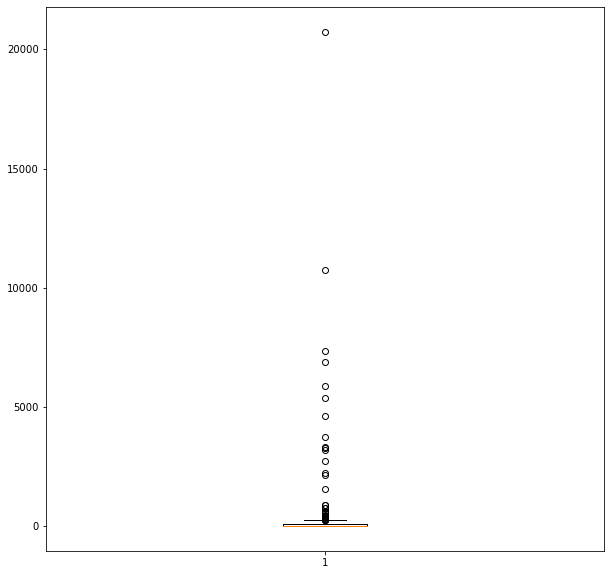

In [73]:
#Caluclate the mean of co2 for each country from 1950 to 2020
countries = filtered_df.country.value_counts(sort=False, ascending=True)
means = []
for country in countries.index:
    means.append(filtered_df[filtered_df.country == country].co2.mean())

#Romeoving NaN
import math
for index, mean in enumerate(means):
    if math.isnan(mean):
        means.remove(mean)

fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(means)

54


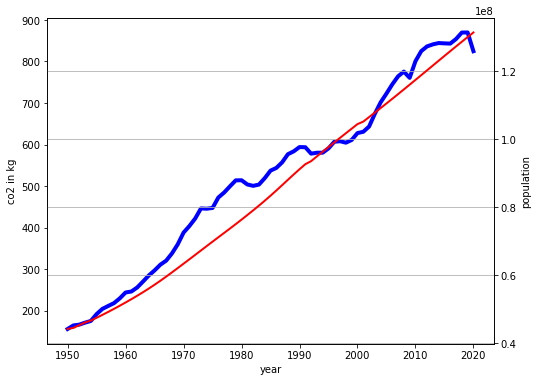

In [74]:
years = filtered_df.year.value_counts(sort=False, ascending=True)

#Calculate co2 mean for each year
co2_means = []
for year in years.index:
    co2_means.append(filtered_df[filtered_df.year == year].co2.mean())

#Calculate population mean for each year
population_means = []
for year in years.index:
    population_means.append(filtered_df[filtered_df.year == year].population.mean())

fig, ax_left = plt.subplots(figsize=(8,6))
ax_right = ax_left.twinx()
    
ax_left.set(ylabel='co2 in kg')
ax_left.set(xlabel='year')
ax_left.plot(years.index, co2_means, linewidth=4.0, 
             color='blue', label='co2 in kg')
ax_right.set(ylabel='population')
ax_right.grid(None)
ax_right.plot(years.index, population_means, linewidth=2.0, 
         color='red', label='ciao')


In [ ]:
#TODO Fare correlazione tra popolazione e co2 
# e tra crescita econimica e co2